In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
from scipy.stats import binned_statistic
def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Use this function for fitting classical flares with most curve_fit
    tools.

    Note: this model assumes the flux before the flare is zero centered

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

In [3]:
N_epoch = 120
Expt = 45. # seconds

time = np.arange(N_epoch * 2) * Expt / 60./60./24.
# we'll end up dropping every-other exposure afterwards (to mimic actual observations)

In [8]:
# set up the quiescent brightness for these 3 fake stars
mag0 = [14, 16, 18]
err0 = [0.02, 0.08, 0.12]

In [9]:
N_flares = [3,3,3] # how many flares to inject into this ~3hr window?
# we'll draw them from a slightly non-physical distribution...

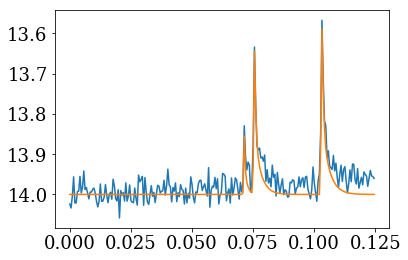

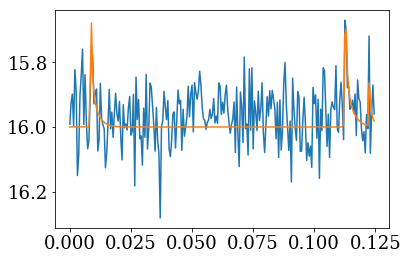

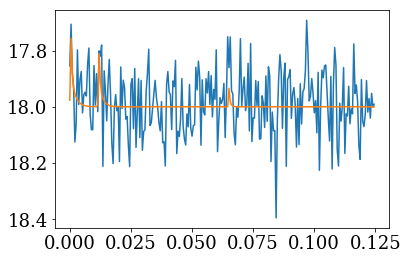

In [23]:
for k in range(len(mag0)):
    flux = np.zeros_like(time)
    for j in range(N_flares[k]):
        tpeak = np.random.random(1)[0] * time.max() # random time
        srand = np.random.random(1)[0] # random size scale of flare, 0-1
        ampl = srand * 0.5 + 0.1 # scale size linearly to amplitude (BAD)
        fwhm = (srand * 60. + 8.) / 60./60./24. # scale size linearly to FWHM (BAD)
        
        flux = flux + aflare1(time, tpeak, fwhm, ampl, upsample=True)

    # plus let's add some small linear offsets
    e_off = time * (-0.3)
    
    # add up random + linear error
    err = np.random.randn(flux.size) * err0[k] + e_off
    
    # make final magnitudes
    mag = -2.5*np.log10(1+flux) + err + mag0[k]
    
    plt.figure()
    plt.plot(time, mag)
    plt.plot(time, -2.5*np.log10(1+flux) + mag0[k])
    plt.gca().invert_yaxis()
    plt.show()
    
    np.random.shuffle(err)
    err = np.abs(err)
    df_out = pd.DataFrame(data={'time':time[np.arange(0,len(time),2)], 
                                'mag':mag[np.arange(0,len(time),2)], 
                                'err':err[np.arange(0,len(time),2)]})
    df_out.to_csv('star'+str(k+1)+'.csv', index=False, columns=('time', 'mag', 'err'))